In [1]:
import torch
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.seed=41
import matplotlib.pyplot as plt

In [2]:
train_set = datasets.MNIST('./data', train=True, download=False)
test_set = datasets.MNIST('./data', train=False, download=False)
train_img = train_set.data.numpy()
test_img = test_set.data.numpy()
train_img = train_img.reshape(-1, 28, 28,1)
train_img.shape

(60000, 28, 28, 1)

In [3]:
batch_size = 200
train_images = torch.Tensor(train_img).view(train_img.shape[0],1,28,28).to(device)
test_images = torch.Tensor(test_img).view(test_img.shape[0],1,28,28).to(device)
train_images.shape

torch.Size([60000, 1, 28, 28])

In [34]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(1,8,2,2,1).to(device), #15
                nn.ReLU(),
                nn.Conv2d(8,16,3,2,1).to(device), #8
                nn.ReLU(),
                nn.Conv2d(16,32,3,1,1).to(device), #8
                nn.ReLU(),
                nn.Conv2d(32,64,4,2,1).to(device), #4
                nn.ReLU(),
                nn.Conv2d(64,128,6,2,1).to(device), #1
                nn.ReLU()
        )
        self.latent_vector_encode=nn.Sequential(
                nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,1,0).to(device), #4
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,2,1).to(device), #8
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,4,2,1).to(device), #16
            nn.ReLU(),
            nn.ConvTranspose2d(8,1,2,2,2).to(device), #28
#             nn.ReLU()
        )
    
    def forward(self,x):
        x=self.encoder(x)
        lat=self.latent_vector_encode(x)
        mean,std=torch.chunk(lat,2,dim=1)
        sample = mean + torch.randn_like(std)*std
        x=sample.view(sample.shape[0],64,1,1)
        x=self.decoder(x)
        return x,mean,std
AutoEncoder = AE()
# AutoEncoder

In [35]:
import torch.optim as optim
optimiser = torch.optim.Adam(AutoEncoder.parameters(), lr=0.01)
loss_list = []

In [36]:
def variational_loss(output,X_in,mean,std):
    loss_function = nn.MSELoss()
    loss_by_function=loss_function(output,X_in)
    kl_loss= -0.005*torch.sum(1+torch.log(torch.pow(std,2)+1e-10)-torch.pow(std,2)-torch.pow(mean,2))
    total_loss=loss_by_function+kl_loss
    return total_loss

In [45]:
def train(X):
    for epoch in range(0,25):
        cost = 0
#         batch = torch.from_numpy(np.arange(0,X.shape[0],dtype="int64"))
#If you would like to check with arange instead of randperm, then uncomment above and comment below lines respectively
        batch=torch.randperm(X.shape[0])
        for i in range(0, X.shape[0],batch_size):
            output,mean,std = AutoEncoder(X[batch[i:i+batch_size]].to(device))
            optimiser.zero_grad()
            loss=variational_loss(output,X[batch[i:i+batch_size]],mean,std)
            cost = cost+loss.item() 
            loss.backward()
            optimiser.step()
        loss_avg = cost / X.shape[0]
        loss_list.append(loss_avg)
        print("For iteration: ", epoch+1, " the loss is :", loss_avg)
#         a=mean.detach().numpy()
#         plt.scatter(a[:,0],a[:,1])
#         break
    return loss_list

For iteration:  1  the loss is : 9.68064380086263
For iteration:  2  the loss is : 9.673133357747396
For iteration:  3  the loss is : 9.643096697998047
For iteration:  4  the loss is : 9.629068572998047
For iteration:  5  the loss is : 9.607040209960937
For iteration:  6  the loss is : 9.545873394775391
For iteration:  7  the loss is : 9.584084383138022
For iteration:  8  the loss is : 9.458235268147787
For iteration:  9  the loss is : 9.51978481648763
For iteration:  10  the loss is : 9.531730499267578
For iteration:  11  the loss is : 9.399484143066406
For iteration:  12  the loss is : 9.390545513916015
For iteration:  13  the loss is : 9.33380986735026
For iteration:  14  the loss is : 9.334656197102865
For iteration:  15  the loss is : 9.333606553141276
For iteration:  16  the loss is : 9.26594682820638
For iteration:  17  the loss is : 9.245519401041667
For iteration:  18  the loss is : 9.265669643147787
For iteration:  19  the loss is : 9.223898026529948
For iteration:  20  the l

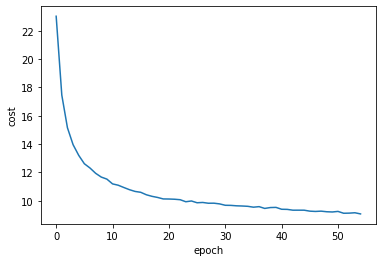

In [46]:
import matplotlib.pyplot as plt
train_loss= train(train_images)
plt.plot(loss_list)
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

In [47]:
def test(X):
    with torch.no_grad():
        cost=0
        batch=torch.randperm(X.shape[0])
        for i in range(0, X.shape[0],batch_size):
            output,mean,std=AutoEncoder(X[batch[i:i+batch_size]])
            loss=variational_loss(output,X[batch[i:i+batch_size]],mean,std)
            cost=cost+loss.item()
        print(cost/X.shape[0])
test(test_images)

9.013905114746093


MNIST Image


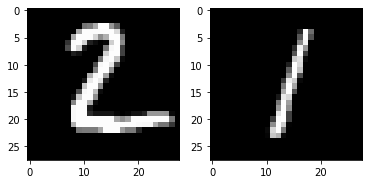

Image through Variational AutoEncoder


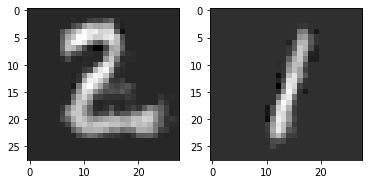

In [49]:
print("MNIST Image")
fig, axes = plt.subplots(1,2)
axes[0].imshow(test_img[1],cmap="gray")
axes[1].imshow(test_img[2],cmap="gray")

plt.show()

print("Image through Variational AutoEncoder")
# print(test_images[1:45].shape)
output=AutoEncoder(test_images[:5])
# print(output[0])
output_img=((output[0].to(torch.device('cpu'))).detach().numpy()).reshape(5,28,28)

fig, axes = plt.subplots(1,2)
axes[0].imshow(output_img[1],cmap="gray")
axes[1].imshow(output_img[2],cmap="gray")
plt.show()

In [33]:
# https://medium.com/@galexik81/5-lifesaving-pytorch-functions-519d134df9b1
#Visit the above blog to know more about torch.chunk